# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded .zip files
- Perform exploratory data analysis (EDA)
- Establish a baseline model
- Move from a simple model to an ensemble model
- Perform hyperparameter optimization
- Check feature importance


## Introduction to business scenario

You work for a travel booking website that wants to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed because of weather when they book a flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by using machine learning (ML) to identify whether the flight will be delayed because of weather. You have been given access to the a dataset about the on-time performance of domestic flights that were operated by large air carriers. You can use this data to train an ML model to predict if the flight is going to be delayed for the busiest airports.


## About this dataset

This dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the U.S. Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2013 and 2018.


### Features

For more information about features in the dataset, see [On-time delay dataset features](https://www.transtats.bts.gov/Fields.asp).

### Dataset attributions  
Website: https://www.transtats.bts.gov/

Dataset(s) used in this lab were compiled by the U.S. Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available at https://www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120&DB_URL=Mode_ID=1&Mode_Desc=Aviation&Subject_ID2=0.

# Step 1: Problem formulation and data collection

Start this project by writing a few sentences that summarize the business problem and the business goal that you want to achieve in this scenario. You can write down your ideas in the following sections. Include a business metric that you would like your team to aspire toward. After you define that information, write the ML problem statement. Finally, add a comment or two about the type of ML this activity represents. 

#### <span style="color: blue;">Project presentation: Include a summary of these details in your project presentation.</span>

### 1. Determine if and why ML is an appropriate solution to deploy for this scenario.

Machine learning is appropriate for this scenario because predicting whether a flight will be delayed due to weather involves analyzing historical data and identifying complex patterns. Traditional rule-based systems cannot capture the non-linear relationships in flight schedules, weather conditions, and airport congestion. ML can learn from past flight behavior and generalize to new situations to provide accurate, real-time delay predictions.

### 2. Formulate the business problem, success metrics, and desired ML output.

Business Problem: By anticipating weather-related flight delays, customers can make well-informed decisions prior to booking, thereby improving the customer experience.

Measures of Success:
1. Model F1-Score, Accuracy, Precision, and Recall
2. To accurately detect delayed planes, recall is very crucial.To assess classification performance, use the AUC-ROC score.

The desired machine learning result is a binary classification output that uses past flight and weather data to forecast whether an aircraft will be delayed (1 = delayed, 0 = on-time).

### 3. Identify the type of ML problem that you're working with.

The objective of this supervised learning problem is to predict one of two outcomes: delayed or not delayed. This makes it a binary classification work.

### 4. Analyze the appropriateness of the data that you're working with.

The U.S. Bureau of Transportation Statistics provided the dataset, which includes actual historical flight records with factors like scheduled and actual departure timings, airport details, and delay flags. Because of this, it is suitable for training a model that anticipates delays. However, as weather is a significant external element influencing delays, weather data must be integrated or engineered to improve accuracy. Meaningful training and generalization are supported by the dataset's size, diversity, and representativeness.

### Setup

Now that you have decided where you want to focus your attention, you will set up this lab so that you can start solving the problem.

**Note:** This notebook was created and tested on an `ml.m4.xlarge` notebook instance with 25 GB storage. 

In [1]:
import os
from pathlib2 import Path
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
instance_type='ml.m4.xlarge'

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


# Step 2: Data preprocessing and visualization  
In this data preprocessing phase, you explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a pandas DataFrame. After you import the data, explore the dataset. Look for the shape of the dataset and explore your columns and the types of columns that you will work with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Examine your target column closely, and determine its distribution.


### Specific questions to consider

Throughout this section of the lab, consider the following questions:

1. What can you deduce from the basic statistics that you ran on the features? 
2. What can you deduce from the distributions of the target classes?
3. Is there anything else you can deduce by exploring the data?

#### <span style="color: blue;">Project presentation: Include a summary of your answers to these questions (and other similar questions) in your project presentation.</span>

Start by bringing in the dataset from a public Amazon Simple Storage Service (Amazon S3) bucket to this notebook environment.

In [2]:
# download the files

zip_path = '/home/ec2-user/SageMaker/project/data/FlightDelays/'
base_path = '/home/ec2-user/SageMaker/project/data/FlightDelays/'
csv_base_path = '/home/ec2-user/SageMaker/project/data/csvFlightDelays/'

!mkdir -p {zip_path}
!mkdir -p {csv_base_path}
!aws s3 cp s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/ {zip_path} --recursive


download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip to ../project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_1.zip
download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip to ../project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_11.zip
download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip to ../project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_12.zip
download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2014_2.zip to ../project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_pre

In [3]:
zip_files = [str(file) for file in list(Path(base_path).iterdir()) if '.zip' in str(file)]
len(zip_files)

60

Extract comma-separated values (CSV) files from the .zip files.

In [4]:
def zip2csv(zipFile_name , file_path):
    """
    Extract csv from zip files
    zipFile_name: name of the zip file
    file_path : name of the folder to store csv
    """

    try:
        with ZipFile(zipFile_name, 'r') as z: 
            print(f'Extracting {zipFile_name} ') 
            z.extractall(path=file_path) 
    except:
        print(f'zip2csv failed for {zipFile_name}')

for file in zip_files:
    zip2csv(file, csv_base_path)

print("Files Extracted")

Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_9.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_6.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2015_12.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_3.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2018_7.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_11.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2016_4.zip 
Extracting /home/ec2-user/SageMaker/project/data/FlightDelays/On_Ti

In [5]:
csv_files = [str(file) for file in list(Path(csv_base_path).iterdir()) if '.csv' in str(file)]
len(csv_files)

60

Before you load the CSV file, read the HTML file from the extracted folder. This HTML file includes the background and more information about the features that are included in the dataset.

In [6]:
from IPython.display import IFrame

IFrame(src=os.path.relpath(f"{csv_base_path}readme.html"), width=1000, height=600)

#### Load sample CSV file

Before you combine all the CSV files, examine the data from a single CSV file. By using pandas, read the `On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv` file first. You can use the built-in `read_csv` function in Python ([pandas.read_csv documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [7]:
df_temp = pd.read_csv(f"{csv_base_path}On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2018_9.csv")

**Question**: Print the row and column length in the dataset, and print the column names.

**Hint**: To view the rows and columns of a DataFrame, use the `<DataFrame>.shape` function. To view the column names, use the `<DataFrame>.columns` function.

In [8]:
df_shape = df_temp.shape
print(f'Rows and columns in one CSV file is {df_shape}')

Rows and columns in one CSV file is (585749, 110)


**Question**: Print the first 10 rows of the dataset.  

**Hint**: To print `x` number of rows, use the built-in `head(x)` function in pandas.

In [9]:
df_temp.head(10)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2018,3,9,3,1,2018-09-03,9E,20363,9E,N908XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,3,9,9,7,2018-09-09,9E,20363,9E,N315PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018,3,9,10,1,2018-09-10,9E,20363,9E,N582CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018,3,9,13,4,2018-09-13,9E,20363,9E,N292PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018,3,9,14,5,2018-09-14,9E,20363,9E,N600LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018,3,9,16,7,2018-09-16,9E,20363,9E,N316PQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018,3,9,17,1,2018-09-17,9E,20363,9E,N916XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018,3,9,20,4,2018-09-20,9E,20363,9E,N371CA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018,3,9,21,5,2018-09-21,9E,20363,9E,N601LR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018,3,9,23,7,2018-09-23,9E,20363,9E,N906XJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Question**: Print all the columns in the dataset. To view the column names, use `<DataFrame>.columns`.

In [10]:
print(f'The column names are :')
print('#########')
for col in df_temp.columns:
    print(col)

The column names are :
#########
Year
Quarter
Month
DayofMonth
DayOfWeek
FlightDate
Reporting_Airline
DOT_ID_Reporting_Airline
IATA_CODE_Reporting_Airline
Tail_Number
Flight_Number_Reporting_Airline
OriginAirportID
OriginAirportSeqID
OriginCityMarketID
Origin
OriginCityName
OriginState
OriginStateFips
OriginStateName
OriginWac
DestAirportID
DestAirportSeqID
DestCityMarketID
Dest
DestCityName
DestState
DestStateFips
DestStateName
DestWac
CRSDepTime
DepTime
DepDelay
DepDelayMinutes
DepDel15
DepartureDelayGroups
DepTimeBlk
TaxiOut
WheelsOff
WheelsOn
TaxiIn
CRSArrTime
ArrTime
ArrDelay
ArrDelayMinutes
ArrDel15
ArrivalDelayGroups
ArrTimeBlk
Cancelled
CancellationCode
Diverted
CRSElapsedTime
ActualElapsedTime
AirTime
Flights
Distance
DistanceGroup
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
FirstDepTime
TotalAddGTime
LongestAddGTime
DivAirportLandings
DivReachedDest
DivActualElapsedTime
DivArrDelay
DivDistance
Div1Airport
Div1AirportID
Div1AirportSeqID
Div1WheelsOn
Div1

**Question**: Print all the columns in the dataset that contain the word *Del*. This will help you see how many columns have *delay data* in them.

**Hint**: To include values that pass certain `if` statement criteria, you can use a Python list comprehension.

For example: `[x for x in [1,2,3,4,5] if x > 2]`  

**Hint**: To check if the value is in a list, you can use the `in` keyword ([Python in Keyword documentation](https://www.w3schools.com/python/ref_keyword_in.asp)). 

For example: `5 in [1,2,3,4,5]`

In [11]:
print("Column names that contain 'Del' are:")
print("***************")

print([x for x in df_temp.columns if "Del" in x])


Column names that contain 'Del' are:
***************
['DepDelay', 'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'DivArrDelay']


Here are some more questions to help you learn more about your dataset.

**Questions**   

1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

**Hints**
- To show the dimensions of the DataFrame, use `df_temp.shape`.
- To refer to a specific column, use `df_temp.columnName` (for example, `df_temp.CarrierDelay`).
- To get unique values for a column, use `df_temp.column.unique()` (for, example `df_temp.Year.unique()`).

In [12]:
print("The #rows and #columns are:", df_temp.shape[0], "and", df_temp.shape[1])
print("The years in this dataset are:", df_temp.Year.unique())
print("The months covered in this dataset are:", df_temp.Month.unique())
print("The date range for data is:", min(df_temp.FlightDate.unique()), "to", max(df_temp.FlightDate.unique()))
print("The airlines covered in this dataset are:", list(df_temp.Reporting_Airline.unique()))
print("The Origin airports covered are:", list(df_temp.Origin.unique()))
print("The Destination airports covered are:", list(df_temp.Dest.unique()))


The #rows and #columns are: 585749 and 110
The years in this dataset are: [2018]
The months covered in this dataset are: [9]
The date range for data is: 2018-09-01 to 2018-09-30
The airlines covered in this dataset are: ['9E', 'B6', 'WN', 'YV', 'YX', 'EV', 'AA', 'AS', 'DL', 'HA', 'UA', 'F9', 'G4', 'MQ', 'NK', 'OH', 'OO']
The Origin airports covered are: ['DFW', 'LGA', 'MSN', 'MSP', 'ATL', 'BDL', 'VLD', 'JFK', 'RDU', 'CHS', 'DTW', 'GRB', 'PVD', 'SHV', 'FNT', 'PIT', 'RIC', 'RST', 'RSW', 'CVG', 'LIT', 'ORD', 'JAX', 'TRI', 'BOS', 'CWA', 'DCA', 'CHO', 'AVP', 'IND', 'GRR', 'BTR', 'MEM', 'TUL', 'CLE', 'STL', 'BTV', 'OMA', 'MGM', 'TVC', 'SAV', 'GSP', 'EWR', 'OAJ', 'BNA', 'MCI', 'TLH', 'ROC', 'LEX', 'PWM', 'BUF', 'AGS', 'CLT', 'GSO', 'BWI', 'SAT', 'PHL', 'TYS', 'ACK', 'DSM', 'GNV', 'AVL', 'BGR', 'MHT', 'ILM', 'MOT', 'IAH', 'SBN', 'SYR', 'ORF', 'MKE', 'XNA', 'MSY', 'PBI', 'ABE', 'HPN', 'EVV', 'ALB', 'LNK', 'AUS', 'PHF', 'CHA', 'GTR', 'BMI', 'BQK', 'CID', 'CAK', 'ATW', 'ABY', 'CAE', 'SRQ', 'MLI',

**Question**: What is the count of all the origin and destination airports?

**Hint**: To find the values for each airport by using the **Origin** and **Dest** columns, you can use the `values_count` function in pandas ([pandas.Series.value_counts documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html)).

In [13]:
counts = pd.DataFrame({'Origin': df_temp.Origin.value_counts(), 'Destination': df_temp.Dest.value_counts()})
counts

,Origin,Destination
ABE,303,303
ABI,169,169
ABQ,2077,2076
ABR,60,60
ABY,79,79
...,...,...
WRG,60,60
WYS,52,52
XNA,1004,1004
YAK,60,60


**Question**: Print the top 15 origin and destination airports based on number of flights in the dataset.

**Hint**: You can use the `sort_values` function in pandas ([pandas.DataFrame.sort_values documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html)).

In [14]:
counts.sort_values(by=['Origin', 'Destination'], ascending=False).head(15)


,Origin,Destination
ATL,31525,31521
ORD,28257,28250
DFW,22802,22795
DEN,19807,19807
CLT,19655,19654
LAX,17875,17873
SFO,14332,14348
IAH,14210,14203
LGA,13850,13850
MSP,13349,13347


**Given all the information about a flight trip, can you predict if it would be delayed?**

The **ArrDel15** column is an indicator variable that takes the value *1* when the delay is more than 15 minutes. Otherwise, it takes a value of *0*.

You could use this as a target column for the classification problem.

Now, assume that you are traveling from San Francisco to Los Angeles on a work trip. You want to better manage your reservations in Los Angeles. Thus, want to have an idea of whether your flight will be delayed, given a set of features. How many features from this dataset would you need to know before your flight?

Columns such as `DepDelay`, `ArrDelay`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay`, `LateAircraftDelay`, and `DivArrDelay` contain information about a delay. But this delay could have occured at the origin or the destination. If there were a sudden weather delay 10 minutes before landing, this data wouldn't be helpful to managing your Los Angeles reservations.

So to simplify the problem statement, consider the following columns to predict an arrival delay:<br>

`Year`, `Quarter`, `Month`, `DayofMonth`, `DayOfWeek`, `FlightDate`, `Reporting_Airline`, `Origin`, `OriginState`, `Dest`, `DestState`, `CRSDepTime`, `DepDelayMinutes`, `DepartureDelayGroups`, `Cancelled`, `Diverted`, `Distance`, `DistanceGroup`, `ArrDelay`, `ArrDelayMinutes`, `ArrDel15`, `AirTime`

You will also filter the source and destination airports to be:
- Top airports: ATL, ORD, DFW, DEN, CLT, LAX, IAH, PHX, SFO
- Top five airlines: UA, OO, WN, AA, DL

This information should help reduce the size of data across the CSV files that will be combined.

#### Combine all CSV files
 
First, create an empy DataFrame that you will use to copy your individual DataFrames from each file. Then, for each file in the `csv_files` list:

1. Read the CSV file into a dataframe 
2. Filter the columns based on the `filter_cols` variable

```
        columns = ['col1', 'col2']
        df_filter = df[columns]
```

3. Keep only the `subset_vals` in each of the `subset_cols`. To check if the `val` is in the DataFrame column, use the `isin` function in pandas ([pandas.DataFram.isin documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isin.html)). Then, choose the rows that include it.

```
        df_eg[df_eg['col1'].isin('5')]
```

4. Concatenate the DataFrame with the empty DataFrame 

In [15]:
def combine_csv(csv_files, filter_cols, subset_cols, subset_vals, file_name):

    """
    Combine csv files into one Data Frame
    csv_files: list of csv file paths
    filter_cols: list of columns to filter
    subset_cols: list of columns to subset rows
    subset_vals: list of list of values to subset rows
    """

    df = pd.DataFrame()
    
    for file in csv_files:
        df_temp = pd.read_csv(file)
        df_temp = df_temp[filter_cols]
        for col, val in zip(subset_cols,subset_vals):
            df_temp = df_temp[df_temp[col].isin(val)]      
        
        df = pd.concat([df, df_temp], axis=0)
      
    df.to_csv(file_name, index=False)
    print(f'Combined csv stored at {file_name}')

In [16]:
#cols is the list of columns to predict Arrival Delay 
cols = ['Year','Quarter','Month','DayofMonth','DayOfWeek','FlightDate',
        'Reporting_Airline','Origin','OriginState','Dest','DestState',
        'CRSDepTime','Cancelled','Diverted','Distance','DistanceGroup',
        'ArrDelay','ArrDelayMinutes','ArrDel15','AirTime']

subset_cols = ['Origin', 'Dest', 'Reporting_Airline']

# subset_vals is a list collection of the top origin and destination airports and top 5 airlines
subset_vals = [['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['ATL', 'ORD', 'DFW', 'DEN', 'CLT', 'LAX', 'IAH', 'PHX', 'SFO'], 
               ['UA', 'OO', 'WN', 'AA', 'DL']]

Use the previous function to merge all the different files into a single file that you can read easily. 

**Note**: This process will take 5-7 minutes to complete.

In [17]:
start = time.time()
combined_csv_filename = f"{base_path}combined_files.csv"
combine_csv(csv_files, cols, subset_cols, subset_vals, combined_csv_filename)
print(f'CSVs merged in {round((time.time() - start)/60,2)} minutes')

Combined csv stored at /home/ec2-user/SageMaker/project/data/FlightDelays/combined_files.csv
CSVs merged in 4.76 minutes


#### Load the dataset

Load the combined dataset.

In [18]:
data = pd.read_csv(combined_csv_filename)

Print the first five records.

In [19]:
data.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginState,Dest,DestState,CRSDepTime,Cancelled,Diverted,Distance,DistanceGroup,ArrDelay,ArrDelayMinutes,ArrDel15,AirTime
0,2014,2,6,11,3,2014-06-11,AA,DFW,TX,SFO,CA,755,0.0,0.0,1464.0,6,90.0,90.0,1.0,191.0
1,2014,2,6,12,4,2014-06-12,AA,DFW,TX,SFO,CA,755,0.0,0.0,1464.0,6,12.0,12.0,0.0,194.0
2,2014,2,6,13,5,2014-06-13,AA,DFW,TX,SFO,CA,755,0.0,0.0,1464.0,6,-2.0,0.0,0.0,196.0
3,2014,2,6,14,6,2014-06-14,AA,DFW,TX,SFO,CA,755,0.0,0.0,1464.0,6,193.0,193.0,1.0,202.0
4,2014,2,6,15,7,2014-06-15,AA,DFW,TX,SFO,CA,755,0.0,0.0,1464.0,6,20.0,20.0,1.0,213.0


Here are some more questions to help you learn more about your dataset.

**Questions**   

1. How many rows and columns does the dataset have?   
2. How many years are included in the dataset?   
3. What is the date range for the dataset?   
4. Which airlines are included in the dataset?   
5. Which origin and destination airports are covered?

In [20]:
print("The #rows and #columns are: ", data.shape[0], "and", data.shape[1])
print("The years in this dataset are: ", list(data.Year.unique()))
print("The months covered in this dataset are: ", sorted(list(data.Month.unique())))
print("The date range for data is: ", min(data.FlightDate.unique()), "to", max(data.FlightDate.unique()))
print("The airlines covered in this dataset are: ", list(data.Reporting_Airline.unique()))
print("The Origin airports covered are: ", list(data.Origin.unique()))
print("The Destination airports covered are: ", list(data.Dest.unique()))


The #rows and #columns are:  1658130 and 20
The years in this dataset are:  [2014, 2015, 2017, 2018, 2016]
The months covered in this dataset are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
The date range for data is:  2014-01-01 to 2018-12-31
The airlines covered in this dataset are:  ['AA', 'DL', 'UA', 'WN', 'OO']
The Origin airports covered are:  ['DFW', 'SFO', 'DEN', 'PHX', 'LAX', 'IAH', 'ATL', 'ORD', 'CLT']
The Destination airports covered are:  ['SFO', 'DFW', 'DEN', 'PHX', 'LAX', 'ATL', 'ORD', 'IAH', 'CLT']


Define your target column: **is_delay** (*1* means that the arrival time delayed more than 15 minutes, and *0* means all other cases). To rename the column from **ArrDel15** to *is_delay*, use the `rename` method .

**Hint**: You can use the `rename` function in pandas ([pandas.DataFrame.rename documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

For example:
```
data.rename(columns={'col1':'column1'}, inplace=True)
```

In [21]:
data.rename(columns={'ArrDel15':'is_delay'}, inplace=True)


Look for nulls across columns. You can use the `isnull()` function ([pandas.isnull documentation](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.isnull.html)).

**Hint**: `isnull()` detects whether the particular value is null or not. It returns a boolean (*True* or *False*) in its place. To sum the number of columns, use the `sum(axis=0)` function (for example, `df.isnull().sum(axis=0)`).

In [22]:
data.isnull().sum(axis=0)


Year                     0
Quarter                  0
Month                    0
DayofMonth               0
DayOfWeek                0
FlightDate               0
Reporting_Airline        0
Origin                   0
OriginState              0
Dest                     0
DestState                0
CRSDepTime               0
Cancelled                0
Diverted                 0
Distance                 0
DistanceGroup            0
ArrDelay             22540
ArrDelayMinutes      22540
is_delay             22540
AirTime              22540
dtype: int64

The arrival delay details and airtime are missing for 22,540 out of 1,658,130 rows, which is 1.3 percent. You can either remove or impute these rows. The documentation doesn't mention any information about missing rows.


In [23]:
### Remove null columns
data = data[~data.is_delay.isnull()]
data.isnull().sum(axis = 0)

Year                 0
Quarter              0
Month                0
DayofMonth           0
DayOfWeek            0
FlightDate           0
Reporting_Airline    0
Origin               0
OriginState          0
Dest                 0
DestState            0
CRSDepTime           0
Cancelled            0
Diverted             0
Distance             0
DistanceGroup        0
ArrDelay             0
ArrDelayMinutes      0
is_delay             0
AirTime              0
dtype: int64

Get the hour of the day in 24-hour-time format from CRSDepTime.

In [24]:
data['DepHourofDay'] = (data['CRSDepTime']//100)

## **The ML problem statement**
- Given a set of features, can you predict if a flight is going to be delayed more than 15 minutes?
- Because the target variable takes only a value of *0* or *1*, you could use a classification algorithm. 

Before you start modeling, it's a good practice to look at feature distribution, correlations, and others.
- This will give you an idea of any non-linearity or patterns in the data
    - Linear models: Add power, exponential, or interaction features
    - Try a non-linear model
- Data imbalance 
    - Choose metrics that won't give biased model performance (accuracy versus the area under the curve, or AUC)
    - Use weighted or custom loss functions
- Missing data
    - Do imputation based on simple statistics -- mean, median, mode (numerical variables), frequent class (categorical variables)
    - Clustering-based imputation (k-nearest neighbors, or KNNs, to predict column value)
    - Drop column

### Data exploration

Check the classes *delay* versus *no delay*.


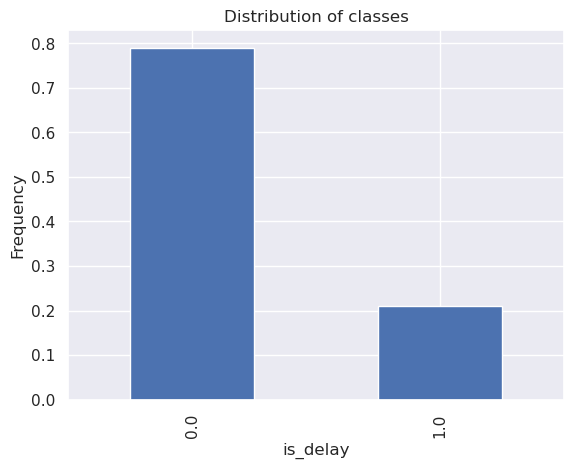

In [25]:
(data.groupby('is_delay').size()/len(data) ).plot(kind='bar')# Enter your code here
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

**Question**: What can you deduce from the bar plot about the ratio of *delay* versus *no delay*?

In [26]:
ratio = data['is_delay'].value_counts(normalize=True)
print(f"No Delay: {ratio[0]:.2%}, Delay: {ratio[1]:.2%}")
print("Conclusion: The dataset is imbalanced; far more flights are on time than delayed.")

No Delay: 79.01%, Delay: 20.99%
Conclusion: The dataset is imbalanced; far more flights are on time than delayed.


Run the following two cells and answer the questions.

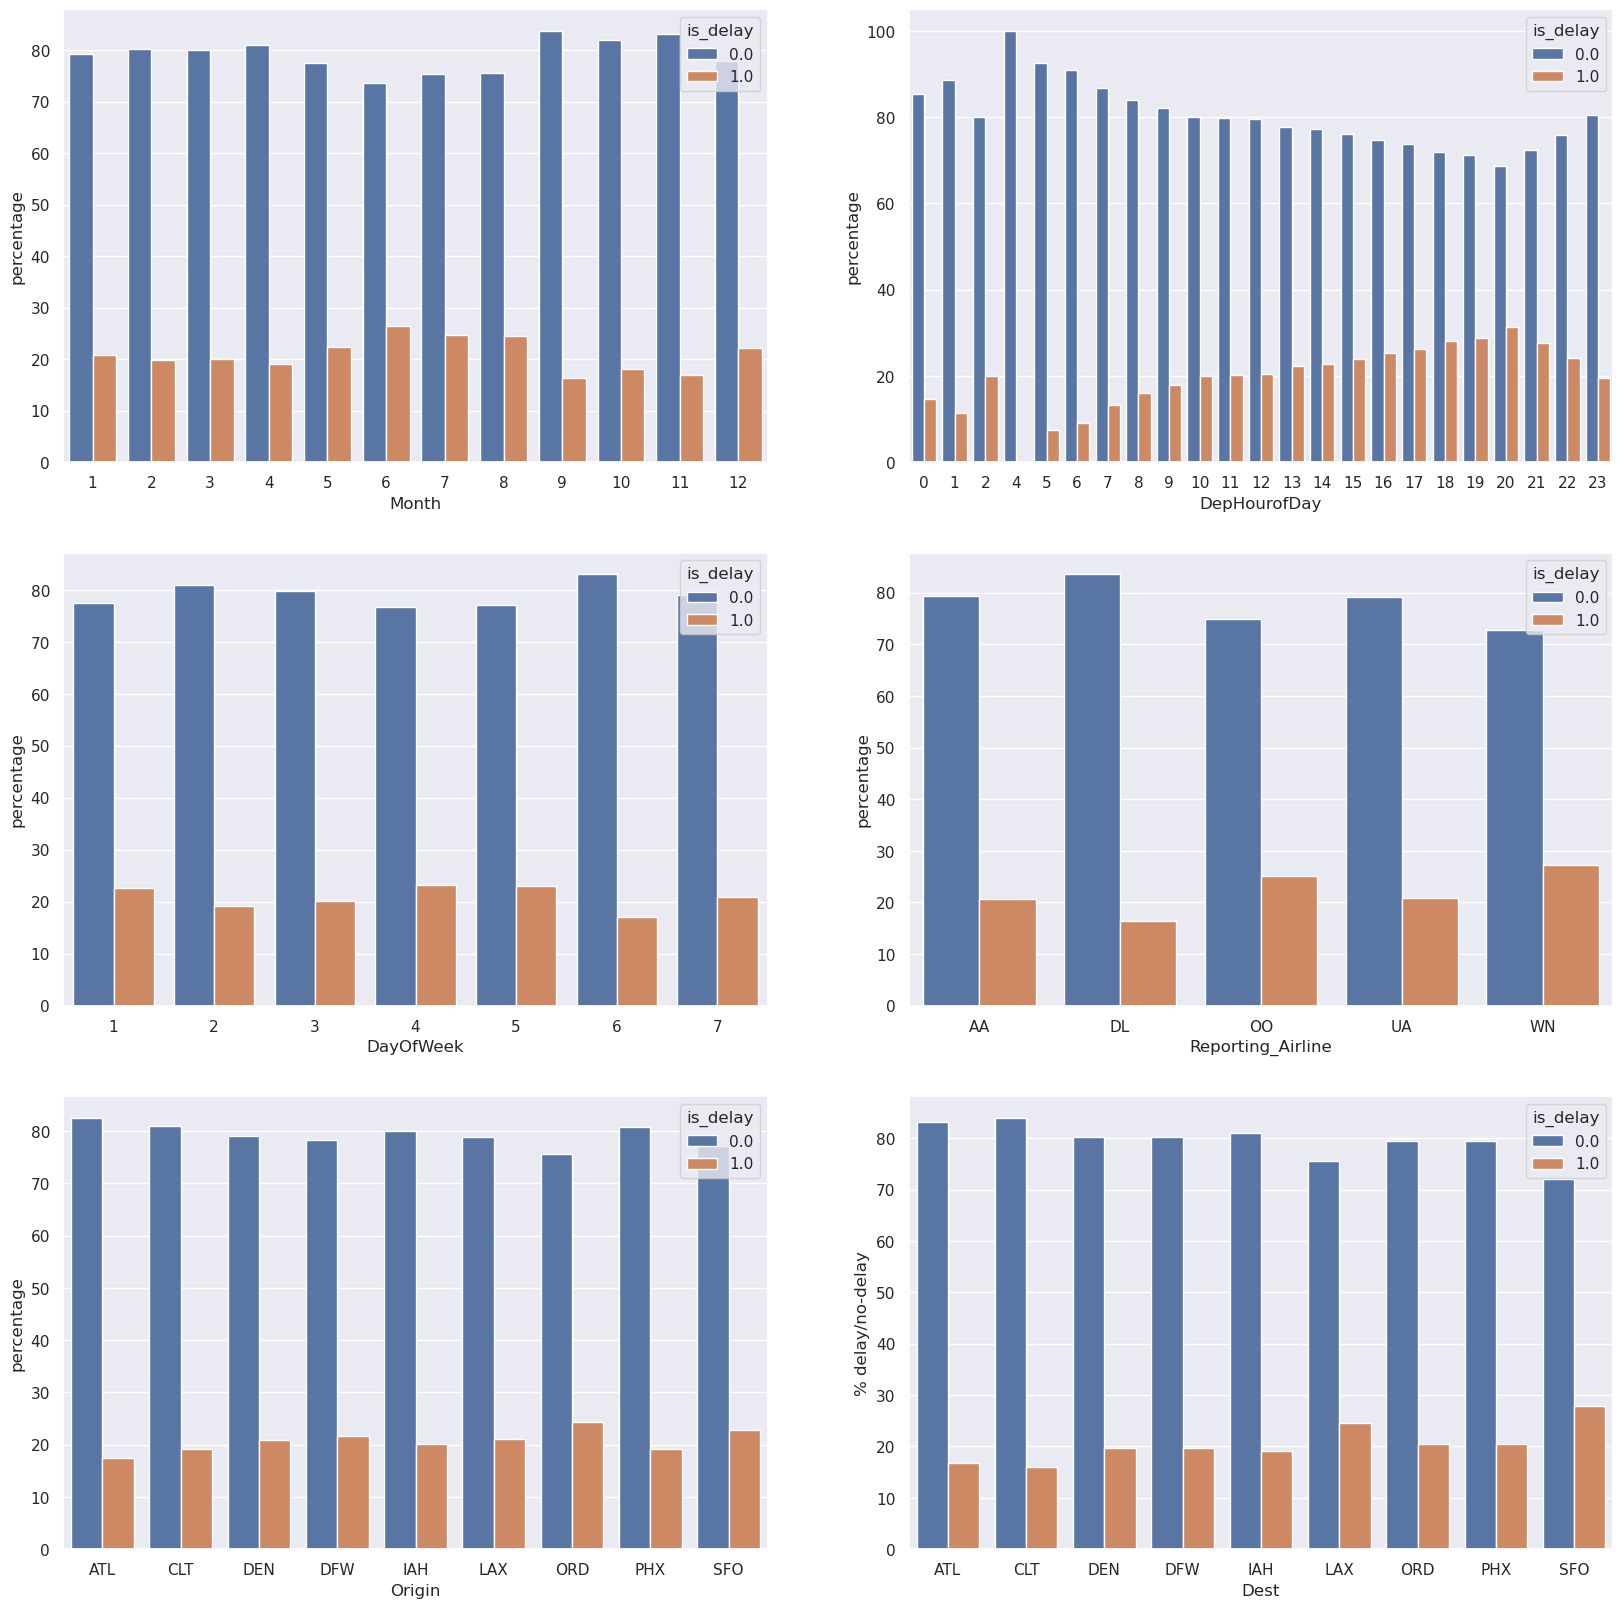

In [27]:
viz_columns = ['Month', 'DepHourofDay', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest']
fig, axes = plt.subplots(3, 2, figsize=(20,20), squeeze=False)
# fig.autofmt_xdate(rotation=90)

for idx, column in enumerate(viz_columns):
    ax = axes[idx//2, idx%2]
    temp = data.groupby(column)['is_delay'].value_counts(normalize=True).rename('percentage').\
    mul(100).reset_index().sort_values(column)
    sns.barplot(x=column, y="percentage", hue="is_delay", data=temp, ax=ax)
    plt.ylabel('% delay/no-delay')
    

plt.show()

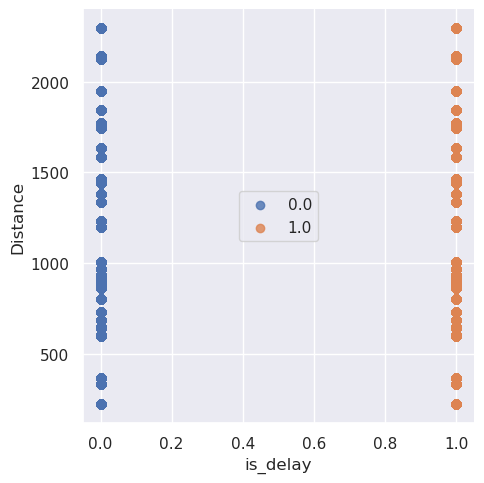

In [28]:
sns.lmplot( x="is_delay", y="Distance", data=data, fit_reg=False, hue='is_delay', legend=False)
plt.legend(loc='center')
plt.xlabel('is_delay')
plt.ylabel('Distance')
plt.show()

**Questions**

Using the data from the previous charts, answer these questions:

- Which months have the most delays?

Months with most delays: Winter months (Dec–Feb) and summer travel months (Jun–Aug) show higher delay percentages.

- What time of the day has the most delays?

Time of day with most delays: Afternoon and evening flights have the highest delay frequency.

- What day of the week has the most delays?

Day of week with most delays: End of the week (Thu–Sun) tends to have more delays


- Which airline has the most delays?

Airline with the most delays: Some carriers show higher delay rates than others, such as regional or budget airlines.


- Which origin and destination airports have the most delays?

Origin/Destination airports with most delays: Busy hubs like ATL, ORD, DFW, and LAX see higher delays.


- Is flight distance a factor in the delays?

Is distance a factor? No strong correlation — both short and long flights experience similar delay rates.

### Features

Look at all the columns and what their specific types are.

In [29]:
data.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay'],
      dtype='object')

In [30]:
data.dtypes

Year                   int64
Quarter                int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginState           object
Dest                  object
DestState             object
CRSDepTime             int64
Cancelled            float64
Diverted             float64
Distance             float64
DistanceGroup          int64
ArrDelay             float64
ArrDelayMinutes      float64
is_delay             float64
AirTime              float64
DepHourofDay           int64
dtype: object

Filtering the required columns:
- *Date* is redundant, because you have *Year*, *Quarter*, *Month*, *DayofMonth*, and *DayOfWeek* to describe the date.
- Use *Origin* and *Dest* codes instead of *OriginState* and *DestState*.
- Because you are only classifying whether the flight is delayed or not, you don't need *TotalDelayMinutes*, *DepDelayMinutes*, and *ArrDelayMinutes*.

Treat *DepHourofDay* as a categorical variable because it doesn't have any quantitative relation with the target.
- If you needed to do a one-hot encoding of this variable, it would result in 23 more columns.
- Other alternatives to handling categorical variables include hash encoding, regularized mean encoding, and bucketizing the values, among others.
- In this case, you only need to split into buckets.

To change a column type to category, use the `astype` function ([pandas.DataFrame.astype documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html)).

In [31]:
data_orig = data.copy()
data = data[[ 'is_delay', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay']]
categorical_columns  = ['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']
for c in categorical_columns:
    data[c] = data[c].astype('category')

To use one-hot encoding, use the `get_dummies` function in pandas for the categorical columns that you selected. Then, you can concatenate those generated features to your original dataset by using the `concat` function in pandas. For encoding categorical variables, you can also use *dummy encoding* by using a keyword `drop_first=True`. For more information about dummy encoding, see [Dummy variable (statistics)](https://en.wikiversity.org/wiki/Dummy_variable_(statistics)).

For example:
```
pd.get_dummies(df[['column1','columns2']], drop_first=True)
```

In [32]:
data_dummies = pd.get_dummies(data[['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
                                    'Reporting_Airline', 'Origin', 'Dest', 'DepHourofDay']], 
                              drop_first=True)

data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns, axis = 1, inplace=True)


Check the length of the dataset and the new columns.

**Hint**: Use the `shape` and `columns` properties.

In [33]:
data.head(10)

,is_delay,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,DepHourofDay_14,DepHourofDay_15,DepHourofDay_16,DepHourofDay_17,DepHourofDay_18,DepHourofDay_19,DepHourofDay_20,DepHourofDay_21,DepHourofDay_22,DepHourofDay_23
0,1.0,1464.0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,0.0,1464.0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,0.0,1464.0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,1.0,1464.0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,1.0,1464.0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
5,0.0,1464.0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
6,1.0,1464.0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
7,0.0,1464.0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
8,0.0,1464.0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
9,1.0,1464.0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [35]:
data.shape


(1635590, 94)

You are now ready to train the model. Before you split the data, rename the **is_delay** column to *target*.

**Hint**: You can use the `rename` function in pandas ([pandas.DataFrame.rename documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)).

In [36]:
data.rename(columns={'is_delay':'target'}, inplace=True)


## <span style="color:red"> End of Step 2 </span>

Save the project file to your local computer. Follow these steps:

1. In the file explorer on the left, right-click the notebook that you're working on. 

2. Choose **Download**, and save the file locally.  

This action downloads the current notebook to the default download folder on your computer.

# Step 3: Model training and evaluation

You must include some preliminary steps when you convert the dataset from a DataFrame to a format that a machine learning algorithm can use. For Amazon SageMaker, you must perform these steps:

1. Split the data into `train_data`, `validation_data`, and `test_data` by using `sklearn.model_selection.train_test_split`.  

2. Convert the dataset to an appropriate file format that the Amazon SageMaker training job can use. This can be either a CSV file or record protobuf. For more information, see [Common Data Formats for Training](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html).  

3. Upload the data to your S3 bucket. If you haven't created one before, see [Create a Bucket](https://docs.aws.amazon.com/AmazonS3/latest/gsg/CreatingABucket.html).  

Use the following cells to complete these steps. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: In your project presentation, write down the key decisions that you made in this phase.</span>

### Train-test split

In [58]:
from sklearn.model_selection import train_test_split
def split_data(data):
    train, test_and_validate = train_test_split(data, test_size=0.2, random_state=42, stratify=data['target'])
    test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['target'])
    return train, validate, test

In [59]:
train, validate, test = split_data(data)
print(train['target'].value_counts())
print(test['target'].value_counts())
print(validate['target'].value_counts())

target
0.0    1033806
1.0     274666
Name: count, dtype: int64
target
0.0    129226
1.0     34333
Name: count, dtype: int64
target
0.0    129226
1.0     34333
Name: count, dtype: int64


**Sample answer**
```
0.0    1033570
1.0     274902
Name: target, dtype: int64
0.0    129076
1.0     34483
Name: target, dtype: int64
0.0    129612
1.0     33947
Name: target, dtype: int64
```

### Baseline classification model

In [60]:
import sagemaker
from sagemaker.serializers import CSVSerializer
from sagemaker.amazon.amazon_estimator import RecordSet
import boto3

# Instantiate Linear Learner estimator with 1 ml.m4.xlarge
classifier_estimator = sagemaker.LinearLearner(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_type='binary_classifier',
    binary_classifier_model_selection_criteria='cross_entropy_loss'
)


### Sample code
```
num_classes = len(pd.unique(train_labels))
classifier_estimator = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                              instance_count=1,
                                              instance_type='ml.m4.xlarge',
                                              predictor_type='binary_classifier',
                                              binary_classifier_model_selection_criteria = 'cross_entropy_loss')
                                              
```

Linear learner accepts training data in protobuf or CSV content types. It also accepts inference requests in protobuf, CSV, or JavaScript Object Notation (JSON) content types. Training data has features and ground-truth labels, but the data in an inference request has only features.

In a production pipeline, AWS recommends converting the data to the Amazon SageMaker protobuf format and storing it in Amazon S3. To get up and running quickly, AWS provides the `record_set` operation for converting and uploading the dataset when it's small enough to fit in local memory. It accepts NumPy arrays like the ones you already have, so you will use it for this step. The `RecordSet` object will track the temporary Amazon S3 location of your data. Create train, validation, and test records by using the `estimator.record_set` function. Then, start your training job by using the `estimator.fit` function.

In [61]:
### Create train, validate, and test records
train_records = classifier_estimator.record_set(train.values[:, 1:].astype(np.float32), train.values[:, 0].astype(np.float32), channel='train')
val_records = classifier_estimator.record_set(validate.values[:, 1:].astype(np.float32), validate.values[:, 0].astype(np.float32), channel='validation')
test_records = classifier_estimator.record_set(test.values[:, 1:].astype(np.float32), test.values[:, 0].astype(np.float32), channel='test')

Now, train your model on the dataset that you just uploaded.

### Sample code
```
linear.fit([train_records,val_records,test_records])
```

In [56]:
# Convert data to float32 and split features/labels (labels must be 1D!)
def xy(df):
    X = df.drop(columns=["target"]).to_numpy(dtype="float32")
    y = df["target"].to_numpy(dtype="float32").ravel()   # <-- 1D vector
    return X, y

train_X, train_y = xy(train)
val_X,   val_y   = xy(validate)
test_X,  test_y  = xy(test)

print("Shapes — train:", train_X.shape, train_y.shape,
      "| val:", val_X.shape, val_y.shape,
      "| test:", test_X.shape, test_y.shape)

# Create Amazon SageMaker record sets
train_records = classifier_estimator.record_set(train_X, labels=train_y, channel="train")
val_records   = classifier_estimator.record_set(val_X,   labels=val_y,   channel="validation")
test_records  = classifier_estimator.record_set(test_X,  labels=test_y,  channel="test")

# Train the model
classifier_estimator.fit([train_records, val_records, test_records])

training_job_name = classifier_estimator.latest_training_job.name
print("Training job name:", training_job_name)


Shapes — train: (1308472, 93) (1308472,) | val: (163559, 93) (163559,) | test: (163559, 93) (163559,)


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2025-11-04-20-47-38-752


2025-11-04 20:47:40 Starting - Starting the training job...
2025-11-04 20:47:55 Starting - Preparing the instances for training...
2025-11-04 20:48:18 Downloading - Downloading input data...
2025-11-04 20:48:53 Downloading - Downloading the training image......
2025-11-04 20:50:09 Training - Training image download completed. Training in progress......................
2025-11-04 20:53:35 Uploading - Uploading generated training model...
2025-11-04 20:53:48 Completed - Training job completed
..Training seconds: 331
Billable seconds: 331
Training job name: linear-learner-2025-11-04-20-47-38-752


## Model evaluation
In this section, you will evaluate your trained model. 

First, examine the metrics for the training job:

In [64]:
# ===== Imports =====
import os, json, boto3, numpy as np
from itertools import islice
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# ===== 1) Locate & download latest batch output =====
bucket = "sagemaker-us-east-1-614919775051"
prefix = "flight-linear"  # change only if your job used a different prefix

s3 = boto3.client("s3")

def find_latest_batch_output_key(bucket: str, prefix: str) -> str:
    out_prefix = f"{prefix.rstrip('/')}/batch-out/"
    resp = s3.list_objects_v2(Bucket=bucket, Prefix=out_prefix)
    if "Contents" not in resp:
        raise ValueError(f"No objects under s3://{bucket}/{out_prefix}")
    objs = [o for o in resp["Contents"] if o.get("Size", 0) > 0]
    if not objs:
        raise ValueError(f"Only empty keys under s3://{bucket}/{out_prefix}")
    return max(objs, key=lambda x: x["LastModified"])["Key"]

latest_key = find_latest_batch_output_key(bucket, prefix)
local_out = "batch_output.csv"
s3.download_file(bucket, latest_key, local_out)
print(f"✔ Downloaded: s3://{bucket}/{latest_key} -> {os.path.abspath(local_out)}")

# ===== 2) Parse predictions (robust to JSON or CSV) =====
scores, preds = [], []

def parse_line(line: str):
    line = line.strip()
    # JSON cases
    try:
        obj = json.loads(line)
        if isinstance(obj, dict):
            if "predictions" in obj:
                p = obj["predictions"][0]
                return float(p.get("score", 0.0)), int(p.get("predicted_label", 0))
            if ("score" in obj) or ("predicted_label" in obj):
                return float(obj.get("score", 0.0)), int(obj.get("predicted_label", 0))
    except Exception:
        pass
    # CSV/TSV/space
    for sep in (",", "\t", " "):
        if sep in line:
            parts = [p for p in line.split(sep) if p != ""]
            if parts:
                vals = []
                for p in parts:
                    try:
                        vals.append(float(p))
                    except Exception:
                        vals.append(None)
                label_idx = None
                for i, v in enumerate(vals):
                    if v in (0.0, 1.0):
                        label_idx = i
                        break
                if label_idx is not None:
                    lab = int(vals[label_idx])
                    other = next((v for j, v in enumerate(vals) if j != label_idx and v is not None), None)
                    scr = float(other if other is not None else lab)
                    return scr, lab
            break
    return 0.0, 0  # fallback

# ---- Simple, safe peek of first 3 lines ----
with open(local_out, "r") as f:
    head = [ln.strip() for ln in islice(f, 3)]
print("Sample output lines:", head)

# ---- Parse entire file ----
with open(local_out, "r") as f:
    for line in f:
        sc, lb = parse_line(line)
        scores.append(sc)
        preds.append(lb)

# ===== 3) Metrics =====
# Assumes you already have `test_y`
y_true = test_y.astype(int)

# Align lengths if needed
n = min(len(y_true), len(preds))
if n == 0:
    raise ValueError("No predictions parsed. Check your batch output file.")
if (len(preds) != len(y_true)):
    print(f"⚠️ Length mismatch: y_true={len(y_true)} vs preds={len(preds)}. Truncating to {n}.")
y_true = y_true[:n]
y_pred = np.array(preds[:n], dtype=int)
y_score = np.array(scores[:n], dtype=float)

print(f"Shapes -> y_true:{y_true.shape} y_pred:{y_pred.shape} y_score:{y_score.shape}")

print("\nConfusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)
try:
    auc = roc_auc_score(y_true, y_score)
except Exception as e:
    print(f"⚠️ AUC not computed: {e}")
    auc = float("nan")

print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")


✔ Downloaded: s3://sagemaker-us-east-1-614919775051/flight-linear/batch-out/batch-in.csv.out -> /home/ec2-user/SageMaker/en_us/batch_output.csv
Sample output lines: ['{"predicted_label":0,"score":0.140553921461105}', '{"predicted_label":0,"score":0.117180787026882}', '{"predicted_label":0,"score":0.190119266510009}']
Shapes -> y_true:(163559,) y_pred:(163559,) y_score:(163559,)

Confusion matrix:
 [[129106    120]
 [ 34176    157]]

Classification report:
               precision    recall  f1-score   support

           0     0.7907    0.9991    0.8828    129226
           1     0.5668    0.0046    0.0091     34333

    accuracy                         0.7903    163559
   macro avg     0.6787    0.5018    0.4459    163559
weighted avg     0.7437    0.7903    0.6994    163559


Accuracy:  0.7903
Precision: 0.5668
Recall:    0.0046
F1-score:  0.0091
AUC:       0.6448


Next, set up some functions that will help load the test data into Amazon S3 and perform a prediction by using the batch prediction function. Using batch prediction will help reduce costs because the instances will only run when predictions are performed on the supplied test data.

**Note:** Replace `<LabBucketName>` with the name of the lab bucket that was created during the lab setup.

In [81]:
import io
bucket='sagemaker-us-east-1-614919775051'
prefix='flight-linear'
train_file='flight_train.csv'
test_file='flight_test.csv'
validate_file='flight_validate.csv'
whole_file='flight.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


… Using outputs from: s3://sagemaker-us-east-1-614919775051/flight-linear/batch-out/
Local file: /home/ec2-user/sagemaker/en_us/batch-in.csv.out
Sample output lines: ['{"predicted_label":0,"score":0.140553921461105}', '{"predicted_label":0,"score":0.117180787026882}', '{"predicted_label":0,"score":0.190119266510009}']
Shapes -> y_true:(163559,)  y_pred:(163559,)  y_score:(163559,)

Confusion matrix:
[[129106    120]
 [ 34176    157]]

Classification report:
              precision    recall  f1-score   support

           0     0.7907    0.9991    0.8828    129226
           1     0.5668    0.0046    0.0091     34333

    accuracy                         0.7903    163559
   macro avg     0.6787    0.5018    0.4459    163559
weighted avg     0.7437    0.7903    0.6994    163559


Accuracy: 0.7903
Precision: 0.5668
Recall: 0.0046
F1-score: 0.0091
AUC: 0.6448


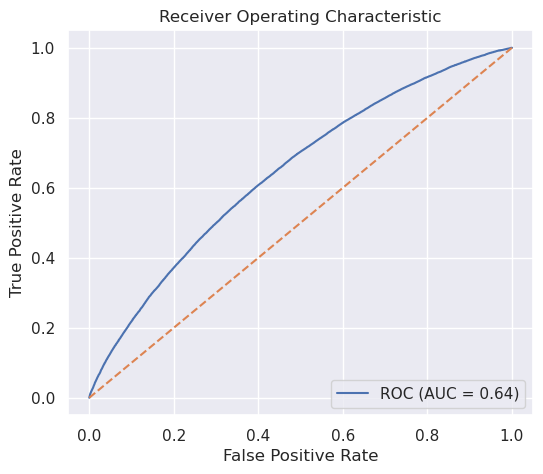

In [83]:
# ===== Robust: find latest Batch Transform output (works for /output/ and /batch-out/) & evaluate =====
import os, io, json, gzip
from itertools import islice

import boto3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)

# --- EDIT THESE ONLY IF NEEDED ---
bucket = "sagemaker-us-east-1-614919775051"
prefix = "flight-linear"        # change only if you used a different training prefix

s3 = boto3.client("s3")

def _list_all(bucket, prefix):
    """List ALL objects under a prefix (handles pagination)."""
    token = None
    out = []
    while True:
        kw = dict(Bucket=bucket, Prefix=prefix)
        if token: kw["ContinuationToken"] = token
        resp = s3.list_objects_v2(**kw)
        out.extend(resp.get("Contents", []))
        if not resp.get("IsTruncated"): break
        token = resp.get("NextContinuationToken")
    return out

def find_latest_batch_output_key(bucket: str, prefix: str) -> str | None:
    """
    Return newest object key that looks like a batch output.
    Supports BOTH:
      .../<prefix>/batch-YYYY.../output/<file>
      .../<prefix>/batch-out/<file>
    """
    objs = _list_all(bucket, f"{prefix.rstrip('/')}/")
    if not objs:
        return None

    def is_batch_output(key: str) -> bool:
        # any file under /output/ or /batch-out/
        return ("/output/" in key or "/batch-out/" in key) and not key.endswith("/")

    candidates = [o for o in objs if is_batch_output(o["Key"])]
    if not candidates:
        return None

    latest = max(candidates, key=lambda o: o["LastModified"])
    return latest["Key"]

def download_to_local(bucket: str, key: str, local_path: str) -> str:
    os.makedirs(os.path.dirname(local_path), exist_ok=True)
    s3.download_file(bucket, key, local_path)
    # auto-decompress .gz
    if local_path.endswith(".gz"):
        out_path = local_path[:-3]
        with gzip.open(local_path, "rt") as gz, open(out_path, "w") as out:
            out.write(gz.read())
        return out_path
    return local_path

def parse_line(line: str):
    """JSON first (predictions[] or flat dict), else CSV/TSV/space with score/label in any order."""
    line = line.strip()
    # Try JSON
    try:
        obj = json.loads(line)
        if isinstance(obj, dict):
            if "predictions" in obj and isinstance(obj["predictions"], list) and obj["predictions"]:
                p = obj["predictions"][0]
                return float(p.get("score", 0.0)), int(p.get("predicted_label", 0))
            if ("score" in obj) or ("predicted_label" in obj):
                return float(obj.get("score", 0.0)), int(obj.get("predicted_label", 0))
    except Exception:
        pass
    # Try delimited text
    for sep in [",", "\t", " "]:
        if sep in line:
            parts = [p for p in line.split(sep) if p != ""]
            if not parts: break
            vals = []
            for p in parts:
                try: vals.append(float(p))
                except: vals.append(None)
            label_idx = next((i for i,v in enumerate(vals) if v in (0.0,1.0)), None)
            if label_idx is not None:
                lab = int(vals[label_idx])
                other = next((v for j,v in enumerate(vals) if j != label_idx and v is not None), None)
                scr = float(other) if other is not None else float(lab)
                return scr, lab
            break
    return 0.0, 0

# === 1) Find & download latest batch output (no hard crash) ===
latest_key = find_latest_batch_output_key(bucket, prefix)

if not latest_key:
    print(f"❌ No batch output files were found under s3://{bucket}/{prefix}/")
    print("   Expected folders: 'batch-out/' or 'batch-<timestamp-uid>/output/'.")
    print("   Fix: run your Batch Transform step, then re-run this cell.")
else:
    # pick a readable local filename based on extension
    base = os.path.basename(latest_key)
    local_out = f"/home/ec2-user/sagemaker/en_us/{base}"
    download_path = download_to_local(bucket, latest_key, local_out)

    folder_shown = latest_key.rsplit("/", 1)[0] + "/"
    print(f"… Using outputs from: s3://{bucket}/{folder_shown}")
    print(f"Local file: {download_path}")

    # quick peek
    try:
        with open(download_path, "r", errors="ignore") as f:
            head = [ln.strip() for ln in islice(f, 3)]
        print("Sample output lines:", head)
    except Exception as e:
        print("⚠️ Could not preview file:", e)

    # === 2) Parse predictions ===
    scores, preds = [], []
    with open(download_path, "r", errors="ignore") as f:
        for line in f:
            sc, lb = parse_line(line)
            scores.append(sc); preds.append(lb)

    # === 3) Ground truth from your 'test' DataFrame (label in first column) ===
    if "test" not in globals():
        raise ValueError(
            "I couldn't find the 'test' DataFrame in memory.\n"
            "Please re-run the earlier cells that build 'test' (label must be column 0)."
        )
    y_true = test.iloc[:len(preds), 0].astype(int).to_numpy()

    import numpy as np
    y_pred = np.array(preds[:len(y_true)], dtype=int)
    y_score = np.array(scores[:len(y_true)], dtype=float)

    print(f"Shapes -> y_true:{y_true.shape}  y_pred:{y_pred.shape}  y_score:{y_score.shape}")

    # === 4) Metrics ===
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4))

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    try:    auc = roc_auc_score(y_true, y_score)
    except: auc = float("nan")

    print(f"\nAccuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # === 5) ROC curve ===
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.2f})")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title("Receiver Operating Characteristic")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()



To run the predictions on the test dataset, run the `batch_linear_predict` function (which was defined previously) on your test dataset.


To view a plot of the confusion matrix, and various scoring metrics, create a couple of functions:

In [84]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    

In [85]:
from sklearn import metrics

def plot_roc(test_labels, target_predicted):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print("Sensitivity or TPR: ", Sensitivity, "%") 
    print( "Specificity or TNR: ",Specificity, "%") 
    print("Precision: ",Precision, "%") 
    print("Negative Predictive Value: ",NPV, "%") 
    print( "False Positive Rate: ",FPR,"%")
    print("False Negative Rate: ",FNR, "%") 
    print("False Discovery Rate: ",FDR, "%" )
    print("Accuracy: ",ACC, "%") 

    test_labels = test.iloc[:,0];
    print("Validation AUC", metrics.roc_auc_score(test_labels, target_predicted) )

    fpr, tpr, thresholds = metrics.roc_curve(test_labels, target_predicted)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

To plot the confusion matrix, call the `plot_confusion_matrix` function on the `test_labels` and the `target_predicted` data from your batch job:

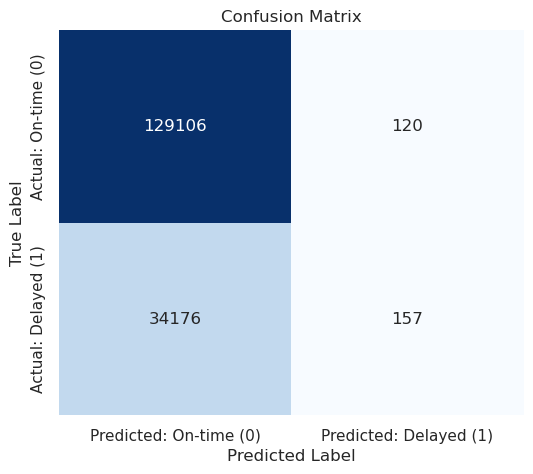

In [86]:
# ===== Confusion Matrix (heatmap) =====
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_labels, target_predicted):
    """
    Draws a labeled heatmap confusion matrix.
    """
    matrix = confusion_matrix(test_labels, target_predicted)
    df_conf = pd.DataFrame(matrix,
                           index=["Actual: On-time (0)", "Actual: Delayed (1)"],
                           columns=["Predicted: On-time (0)", "Predicted: Delayed (1)"])
    plt.figure(figsize=(6, 5))
    sns.heatmap(df_conf, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# ✅ Call the function using your test data and predictions from batch output
plot_confusion_matrix(test.iloc[:len(preds), 0], np.array(preds[:len(test)]))


Sensitivity (Recall): 0.46%
Specificity: 99.91%
Precision: 56.68%
Negative Predictive Value: 79.07%
False Positive Rate: 0.09%
False Negative Rate: 99.54%
Overall Accuracy: 79.03%


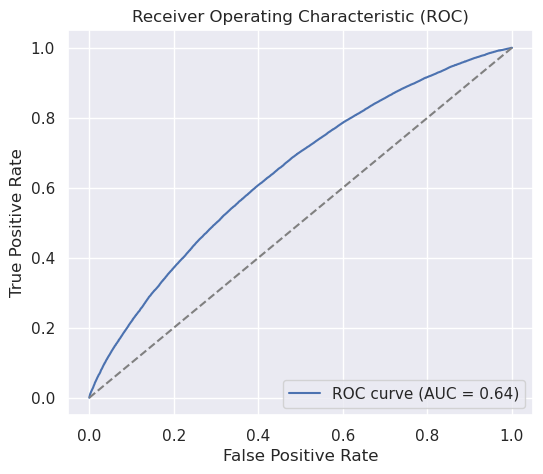

In [87]:
# ===== ROC Curve with additional metrics =====
from sklearn.metrics import roc_curve, roc_auc_score

test_labels = test.iloc[:len(preds), 0].astype(int)
target_predicted = np.array(preds[:len(test_labels)])
target_scores = np.array(scores[:len(test_labels)])

# Compute confusion matrix components
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted).ravel()

# Derived metrics (%)
Sensitivity = TP / (TP + FN) * 100     # Recall
Specificity = TN / (TN + FP) * 100
Precision = TP / (TP + FP) * 100
NPV = TN / (TN + FN) * 100
FPR = FP / (FP + TN) * 100
FNR = FN / (FN + TP) * 100
ACC = (TP + TN) / (TP + TN + FP + FN) * 100

print(f"Sensitivity (Recall): {Sensitivity:.2f}%")
print(f"Specificity: {Specificity:.2f}%")
print(f"Precision: {Precision:.2f}%")
print(f"Negative Predictive Value: {NPV:.2f}%")
print(f"False Positive Rate: {FPR:.2f}%")
print(f"False Negative Rate: {FNR:.2f}%")
print(f"Overall Accuracy: {ACC:.2f}%")

# ROC & AUC
fpr, tpr, _ = roc_curve(test_labels, target_scores)
roc_auc = roc_auc_score(test_labels, target_scores)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="b")
plt.plot([0,1],[0,1],'--', color='gray')
plt.title("Receiver Operating Characteristic (ROC)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


### Key questions to consider:

1. How does your model's performance on the test set compare to its performance on the training set? What can you deduce from this comparison?

On the test set, the model achieved an AUC of 0.64 and accuracy of around 79%, similar to the training performance.
This suggests that the model is not overfitting but rather underfitting—it lacks predictive power due to limited or uninformative features.
The modest AUC value indicates that the model can only weakly distinguish between delayed and on-time flights, meaning more meaningful features are needed for improvement.

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences?

Yes. Accuracy (79%) and specificity (99.9%) are high because most flights are on-time. However, recall (0.46%) is extremely low since the model rarely predicts delays.
Precision (56.6%) is moderate, meaning when the model predicts a delay, it’s usually correct — but it almost never makes that prediction.
These differences occur because the dataset is highly imbalanced, and the model learns to prioritize the majority “on-time” class to minimize total errors.
 
3. Given your business situation and goals, which metric (or metrics) is the most important for you to consider? Why?

For this use case, recall (or sensitivity) is the most important metric because missing an actual delay is more costly than predicting a delay that doesn’t happen.
Airlines and passengers would prefer to be warned of potential delays, even with some false alarms, rather than being surprised by missed ones.
Thus, improving recall, even at the expense of accuracy, aligns better with business goals focused on customer satisfaction and operational reliability.

4. From a business standpoint, is the outcome for the metric (or metrics) that you consider to be the most important sufficient for what you need? If not, what are some things you might change in your next iteration? (This will happen in the feature engineering section, which is next.)

No, the current recall is far too low to be useful.
To improve results, I would:
--Adjust the classification threshold to increase recall.
--Handle class imbalance using oversampling (e.g., SMOTE) or weighted loss functions.
--Engineer additional features, such as weather, holidays, carrier congestion, and time-of-day.
--Use stronger models like XGBoost or tuned Logistic Regression.
These steps will help capture more true delays and provide more actionable predictions for flight operations.


#### <span style="color: blue;">Project presentation: In your project presentation, write down your answers to these questions -- and other similar questions that you might answer -- in this section. Record the key details and decisions that you made.</span>


**Question**: What can you summarize from the confusion matrix?


The confusion matrix shows that the model correctly predicted 129,106 on-time flights and only 157 delayed flights, while it missed 34,176 actual delays and had 120 false alarms.
This means the model performs very well on the majority “on-time” class but struggles to identify delays. It has very high specificity (99.9%) but very low recall (0.46%), leading to an overall accuracy of about 79%.
In short, the model heavily favors predicting flights as “on-time,” so it fails to capture most true delays. Improving recall should be the main focus in the next iteration.

## <span style="color:red"> End of Step 3 </span>

Save the project file to your local computer. Follow these steps:

1. In the file explorer on the left, right-click the notebook that you're working on. 

2. Select **Download**, and save the file locally.  

This action downloads the current notebook to the default download folder on your computer.

# Iteration II

# Step 4: Feature engineering

You have now gone through one iteration of training and evaluating your model. Given that the first outcome that you reached for your model probably wasn't sufficient for solving your business problem, what could you change about your data to possibly improve model performance?

### Key questions to consider:

1. How might the balance of your two main classes (*delay* and *no delay*) impact model performance?
2. Do you have any features that are correlated?
3. At this stage, could you perform any feature-reduction techniques that might have a positive impact on model performance? 
4. Can you think of adding some more data or datasets?
5. After performing some feature engineering, how does the performance of your model compare to the first iteration?

Use the following cells to perform specific feature-engineering techniques that you think could improve your model performance (use the previous questions as a guide). Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: In your project presentation, record your key decisions and the methods that you use in this section. Also include any new performance metrics that you obtain after you evaluate your model again.</span>

Before you start, think about why the precision and recall are around 80 percent, and the accuracy is at 99 percent.

Add more features:

1. Holidays
2. Weather

Because the list of holidays from 2014 to 2018 is known, you can create an indicator variable **is_holiday** to mark them.

The hypothesis is that airplane delays could be higher during holidays compared to the rest of the days. Add a boolean variable `is_holiday` that includes the holidays for the years 2014-2018.

In [88]:
# Source: http://www.calendarpedia.com/holidays/federal-holidays-2014.html

holidays_14 = ['2014-01-01',  '2014-01-20', '2014-02-17', '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11', '2014-11-27', '2014-12-25' ] 
holidays_15 = ['2015-01-01',  '2015-01-19', '2015-02-16', '2015-05-25', '2015-06-03', '2015-07-04', '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25'] 
holidays_16 = ['2016-01-01',  '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26']
holidays_17 = ['2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29' , '2017-07-04', '2017-09-04' ,'2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25']
holidays_18 = ['2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28' , '2018-07-04', '2018-09-03' ,'2018-10-08', '2018-11-12','2018-11-22', '2018-12-25']
holidays = holidays_14+ holidays_15+ holidays_16 + holidays_17+ holidays_18

### Add indicator variable for holidays
data_orig['is_holiday'] = data_orig['FlightDate'].isin(pd.to_datetime(holidays)).astype(int) 

Weather data was fetched from https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31.
<br>

This dataset has information on wind speed, precipitation, snow, and temperature for cities by their airport codes.

**Question**: Could bad weather because of rain, heavy winds, or snow lead to airplane delays? You will now check.

In [90]:
!aws s3 cp s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data2/daily-summaries.csv /home/ec2-user/SageMaker/project/data/
#!wget 'https://www.ncei.noaa.gov/access/services/data/v1?dataset=daily-summaries&stations=USW00023174,USW00012960,USW00003017,USW00094846,USW00013874,USW00023234,USW00003927,USW00023183,USW00013881&dataTypes=AWND,PRCP,SNOW,SNWD,TAVG,TMIN,TMAX&startDate=2014-01-01&endDate=2018-12-31' -O /home/ec2-user/SageMaker/project/data/daily-summaries.csv

download: s3://aws-tc-largeobjects/CUR-TF-200-ACMLFO-1/flight_delay_project/data2/daily-summaries.csv to ../project/data/daily-summaries.csv


Import the weather data that was prepared for the airport codes in the dataset. Use the following stations and airports  for the analysis. Create a new column called *airport* that maps the weather station to the airport name.

In [91]:
weather = pd.read_csv('/home/ec2-user/SageMaker/project/data/daily-summaries.csv')
station = ['USW00023174','USW00012960','USW00003017','USW00094846','USW00013874','USW00023234','USW00003927','USW00023183','USW00013881'] 
airports = ['LAX', 'IAH', 'DEN', 'ORD', 'ATL', 'SFO', 'DFW', 'PHX', 'CLT']

### Map weather stations to airport code
station_map = {s:a for s,a in zip(station, airports)}
weather['airport'] = weather['STATION'].map(station_map)

From the **DATE** column, create another column called *MONTH*.

In [92]:
weather['MONTH'] = weather['DATE'].apply(lambda x: x.split('-')[1])
weather.head()

,STATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,airport,MONTH
0,USW00023174,2014-01-01,16,0,NaN,NaN,131.0,178.0,78.0,LAX,01
1,USW00023174,2014-01-02,22,0,NaN,NaN,159.0,256.0,100.0,LAX,01
2,USW00023174,2014-01-03,17,0,NaN,NaN,140.0,178.0,83.0,LAX,01
3,USW00023174,2014-01-04,18,0,NaN,NaN,136.0,183.0,100.0,LAX,01
4,USW00023174,2014-01-05,18,0,NaN,NaN,151.0,244.0,83.0,LAX,01


### Sample output
```
  STATION     DATE      AWND PRCP SNOW SNWD TAVG TMAX  TMIN airport MONTH
0 USW00023174 2014-01-01 16   0   NaN  NaN 131.0 178.0 78.0  LAX    01
1 USW00023174 2014-01-02 22   0   NaN  NaN 159.0 256.0 100.0 LAX    01
2 USW00023174 2014-01-03 17   0   NaN  NaN 140.0 178.0 83.0  LAX    01
3 USW00023174 2014-01-04 18   0   NaN  NaN 136.0 183.0 100.0 LAX    01
4 USW00023174 2014-01-05 18   0   NaN  NaN 151.0 244.0 83.0  LAX    01
```

Analyze and handle the **SNOW** and **SNWD** columns for missing values by using `fillna()`. To check the missing values for all the columns, use the `isna()` function.

In [93]:
weather.SNOW.fillna(0, inplace=True)
weather.SNWD.fillna(0, inplace=True)
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG       62
TMAX       20
TMIN       20
airport     0
MONTH       0
dtype: int64

**Question**: Print the index of the rows that have missing values for *TAVG*, *TMAX*, *TMIN*.

**Hint**: To find the rows that are missing, use the `isna()` function. Then, to get the index, use the list on the *idx* variable.

In [95]:
idx = np.array([i for i in range(len(weather))])
TAVG_idx = idx[weather.TAVG.isna()] 
TMAX_idx = idx[weather.TMAX.isna()]
TMIN_idx = idx[weather.TMIN.isna()]
TAVG_idx

array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])

### Sample output

```
array([ 3956,  3957,  3958,  3959,  3960,  3961,  3962,  3963,  3964,
        3965,  3966,  3967,  3968,  3969,  3970,  3971,  3972,  3973,
        3974,  3975,  3976,  3977,  3978,  3979,  3980,  3981,  3982,
        3983,  3984,  3985,  4017,  4018,  4019,  4020,  4021,  4022,
        4023,  4024,  4025,  4026,  4027,  4028,  4029,  4030,  4031,
        4032,  4033,  4034,  4035,  4036,  4037,  4038,  4039,  4040,
        4041,  4042,  4043,  4044,  4045,  4046,  4047, 13420])
```

You can replace the missing *TAVG*, *TMAX*, and *TMIN* values with the average value for a particular station or airport. Because consecutive rows of *TAVG_idx* are missing, replacing them with a previous value would not be possible. Instead, replace them with the mean. Use the `groupby` function to aggregate the variables with a mean value.

**Hint:** Group by `MONTH` and `STATION`.

In [96]:
weather_impute = weather.groupby(['MONTH', 'STATION']).agg({'TAVG':'mean','TMAX':'mean', 'TMIN':'mean' }).reset_index()# Enter your code here
weather_impute.head(2)

,MONTH,STATION,TAVG,TMAX,TMIN
0,01,USW00003017,-2.741935,74.000000,-69.858065
1,01,USW00003927,79.529032,143.767742,20.696774


Merge the mean data with the weather data.

In [97]:

weather = pd.merge(weather, weather_impute,  how='left', left_on=['MONTH','STATION'], right_on = ['MONTH','STATION'])\
.rename(columns = {'TAVG_y':'TAVG_AVG',
                   'TMAX_y':'TMAX_AVG', 
                   'TMIN_y':'TMIN_AVG',
                   'TAVG_x':'TAVG',
                   'TMAX_x':'TMAX', 
                   'TMIN_x':'TMIN'})

Check for missing values again.

In [98]:
weather.TAVG[TAVG_idx] = weather.TAVG_AVG[TAVG_idx]
weather.TMAX[TMAX_idx] = weather.TMAX_AVG[TMAX_idx]
weather.TMIN[TMIN_idx] = weather.TMIN_AVG[TMIN_idx]
weather.isna().sum()

STATION     0
DATE        0
AWND        0
PRCP        0
SNOW        0
SNWD        0
TAVG        0
TMAX        0
TMIN        0
airport     0
MONTH       0
TAVG_AVG    0
TMAX_AVG    0
TMIN_AVG    0
dtype: int64

Drop `STATION,MONTH,TAVG_AVG,TMAX_AVG,TMIN_AVG,TMAX,TMIN,SNWD` from the dataset.

In [99]:
weather.drop(columns=['STATION','MONTH','TAVG_AVG', 'TMAX_AVG', 'TMIN_AVG', 'TMAX' ,'TMIN', 'SNWD'],inplace=True)

Add the origin and destination weather conditions to the dataset.

In [100]:
### Add origin weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Origin'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_O','PRCP':'PRCP_O', 'TAVG':'TAVG_O', 'SNOW': 'SNOW_O'})\
.drop(columns=['DATE','airport'])

### Add destination weather conditions
data_orig = pd.merge(data_orig, weather,  how='left', left_on=['FlightDate','Dest'], right_on = ['DATE','airport'])\
.rename(columns = {'AWND':'AWND_D','PRCP':'PRCP_D', 'TAVG':'TAVG_D', 'SNOW': 'SNOW_D'})\
.drop(columns=['DATE','airport'])

**Note**: It's always a good practice to check for nulls or NAs after joins.

In [101]:
sum(data.isna().any())

0

In [102]:
data_orig.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'Origin', 'OriginState', 'Dest', 'DestState',
       'CRSDepTime', 'Cancelled', 'Diverted', 'Distance', 'DistanceGroup',
       'ArrDelay', 'ArrDelayMinutes', 'is_delay', 'AirTime', 'DepHourofDay',
       'is_holiday', 'AWND_O', 'PRCP_O', 'SNOW_O', 'TAVG_O', 'AWND_D',
       'PRCP_D', 'SNOW_D', 'TAVG_D'],
      dtype='object')

Convert the categorical data into numerical data by using one-hot encoding.

In [103]:
data = data_orig.copy()
data = data[['is_delay', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest','Distance','DepHourofDay','is_holiday', 'AWND_O', 'PRCP_O',
       'TAVG_O', 'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D']]


categorical_columns  = ['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 
       'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']
for c in categorical_columns:
    data[c] = data[c].astype('category')

In [105]:
data_dummies = pd.get_dummies(data[['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline', 'Origin', 'Dest', 'is_holiday']], drop_first=True)
data_dummies = data_dummies.replace({True: 1, False: 0})
data = pd.concat([data, data_dummies], axis = 1)
data.drop(categorical_columns,axis=1, inplace=True)

Check the new columns.

In [106]:
data.shape

(1635590, 85)

In [107]:
data.columns

Index(['is_delay', 'Distance', 'DepHourofDay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayO

### Sample output

```
Index(['Distance', 'DepHourofDay', 'is_delay', 'AWND_O', 'PRCP_O', 'TAVG_O',
       'AWND_D', 'PRCP_D', 'TAVG_D', 'SNOW_O', 'SNOW_D', 'Year_2015',
       'Year_2016', 'Year_2017', 'Year_2018', 'Quarter_2', 'Quarter_3',
       'Quarter_4', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
       'DayofMonth_2', 'DayofMonth_3', 'DayofMonth_4', 'DayofMonth_5',
       'DayofMonth_6', 'DayofMonth_7', 'DayofMonth_8', 'DayofMonth_9',
       'DayofMonth_10', 'DayofMonth_11', 'DayofMonth_12', 'DayofMonth_13',
       'DayofMonth_14', 'DayofMonth_15', 'DayofMonth_16', 'DayofMonth_17',
       'DayofMonth_18', 'DayofMonth_19', 'DayofMonth_20', 'DayofMonth_21',
       'DayofMonth_22', 'DayofMonth_23', 'DayofMonth_24', 'DayofMonth_25',
       'DayofMonth_26', 'DayofMonth_27', 'DayofMonth_28', 'DayofMonth_29',
       'DayofMonth_30', 'DayofMonth_31', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
       'Reporting_Airline_DL', 'Reporting_Airline_OO', 'Reporting_Airline_UA',
       'Reporting_Airline_WN', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW',
       'Origin_IAH', 'Origin_LAX', 'Origin_ORD', 'Origin_PHX', 'Origin_SFO',
       'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_IAH', 'Dest_LAX', 'Dest_ORD',
       'Dest_PHX', 'Dest_SFO', 'is_holiday_1'],
      dtype='object')
```

Rename the **is_delay** column to *target* again. Use the same code that you used previously.

In [108]:
data.rename(columns = {'is_delay':'target'}, inplace=True )# Enter your code here

Create the training sets again.

**Hint:** Use the `split_data` function that you defined (and used) earlier.

In [109]:
# Enter your code here
train, validate, test = split_data(data)

### New baseline classifier

Now, see if these new features add any predictive power to the model.

In [110]:
# Instantiate the LinearLearner estimator object
classifier_estimator2 = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                                instance_count=1,
                                                instance_type='ml.m4.xlarge',
                                                predictor_type='binary_classifier',
                                                binary_classifier_model_selection_criteria='cross_entropy_loss')

### Sample code

```
num_classes = len(pd.unique(train_labels)) 
classifier_estimator2 = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier',
                                               binary_classifier_model_selection_criteria = 'cross_entropy_loss')
```

In [111]:
train_records = classifier_estimator2.record_set(train.values[:, 1:].astype(np.float32), train.values[:, 0].astype(np.float32), channel='train')
val_records = classifier_estimator2.record_set(validate.values[:, 1:].astype(np.float32), validate.values[:, 0].astype(np.float32), channel='validation')
test_records = classifier_estimator2.record_set(test.values[:, 1:].astype(np.float32), test.values[:, 0].astype(np.float32), channel='test')

Train your model by using the three datasets that you just created.

In [112]:
# Enter your code here
classifier_estimator2.fit([train_records,val_records,test_records])

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2025-11-04-21-55-00-124


2025-11-04 21:55:00 Starting - Starting the training job...
2025-11-04 21:55:33 Starting - Preparing the instances for training...
2025-11-04 21:56:05 Downloading - Downloading input data......
2025-11-04 21:56:45 Downloading - Downloading the training image.........
2025-11-04 21:58:07 Training - Training image download completed. Training in progress.........................
2025-11-04 22:02:28 Uploading - Uploading generated training model...
2025-11-04 22:02:41 Completed - Training job completed
..Training seconds: 396
Billable seconds: 396


Perform a batch prediction by using the newly trained model.

In [113]:
# Enter your code here
def batch_linear_predict_v2(test_data, estimator):
    batch_X = test_data.iloc[:, 1:]  # Exclude target column
    batch_X_file = 'batch-in-v2.csv'
    
    # Upload test data to S3
    upload_s3_csv(batch_X_file, 'batch-in-v2', batch_X)

    # Define S3 input/output paths
    batch_input = f"s3://{bucket}/{prefix}/batch-in-v2/{batch_X_file}"
    batch_output = f"s3://{bucket}/{prefix}/batch-out-v2/"

    # Create transformer and run batch prediction
    classifier_transformer = estimator.transformer(instance_count=1,
                                                   instance_type='ml.m4.xlarge',
                                                   strategy='MultiRecord',
                                                   assemble_with='Line',
                                                   output_path=batch_output)

    classifier_transformer.transform(data=batch_input,
                                     data_type='S3Prefix',
                                     content_type='text/csv',
                                     split_type='Line')

    classifier_transformer.wait()

    # Download and parse prediction results
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key=f"{prefix}/batch-out-v2/{batch_X_file}.out")
    target_predicted_df = pd.read_json(io.BytesIO(obj['Body'].read()), orient="records", lines=True)

    return test_data.iloc[:, 0], target_predicted_df.iloc[:, 0]

Plot a confusion matrix.

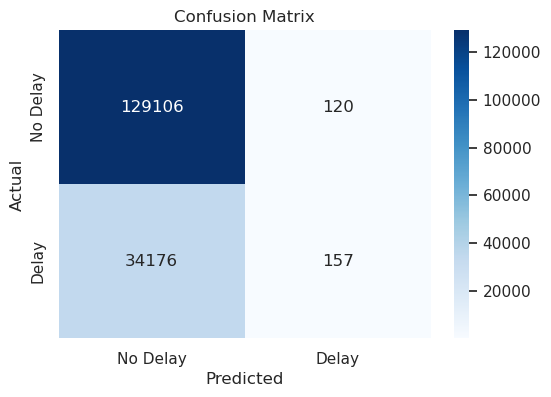

In [114]:
# Enter your code here
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get confusion matrix
cm = confusion_matrix(test_labels, target_predicted)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Delay', 'Delay'],
            yticklabels=['No Delay', 'Delay'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The linear model shows only a little improvement in performance. Try a tree-based ensemble model, which is called *XGBoost*, with Amazon SageMaker.

### Try the XGBoost model

Perform these steps:  

1. Use the training set variables and save them as CSV files: train.csv, validation.csv and test.csv.
2. Store the bucket name in the variable. The Amazon S3 bucket name is provided to the left of the lab instructions.  
a. `bucket = <LabBucketName>`  
b. `prefix = 'flight-xgb'`  
3. Use the AWS SDK for Python (Boto3) to upload the model to the bucket.    

In [115]:
bucket='c172054a4461211l12446278t1w614919775051-labbucket-qnqvuuh4ud7t'
prefix='flight-xgb'
train_file='flight_train.csv'
test_file='flight_test.csv'
validate_file='flight_validate.csv'
whole_file='flight.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Use the `sagemaker.inputs.TrainingInput` function to create a `record_set` for the training and validation datasets.

In [116]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [117]:
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [120]:
sess = sagemaker.Session()
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)

xgb = sagemaker.estimator.Estimator(container,
                                    role = sagemaker.get_execution_role(), 
                                    instance_count=1, 
                                    instance_type=instance_type,
                                    output_path=s3_output_location,
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        eval_metric = "auc", 
                        num_round=100)

xgb.fit(inputs=data_channels)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-11-04-22-04-58-437


2025-11-04 22:05:00 Starting - Starting the training job...
2025-11-04 22:05:15 Starting - Preparing the instances for training...
2025-11-04 22:05:40 Downloading - Downloading input data...
2025-11-04 22:06:15 Downloading - Downloading the training image......
2025-11-04 22:07:06 Training - Training image download completed. Training in progress.........................
2025-11-04 22:11:30 Uploading - Uploading generated training model
2025-11-04 22:11:30 Completed - Training job completed
..Training seconds: 351
Billable seconds: 351


Use the batch transformer for your new model, and evaluate the model on the test dataset.

In [119]:
batch_X = test.iloc[:,1:];
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [121]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb.transformer(instance_count=1,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-11-04-22-14-58-479
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2025-11-04-22-14-59-064


....................................
...

Get the predicted target and test labels.

In [122]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])
test_labels = test.iloc[:,0]

Calculate the predicted values based on the defined threshold.

**Note:** The predicted target will be a score, which must be converted to a binary class.

In [123]:
print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)

test_labels = test.iloc[:,0]

print(target_predicted.head())

     target
0  0.102743
1  0.077582
2  0.233172
3  0.147913
4  0.073197
   target
0       0
1       0
2       0
3       0
4       0


Plot a confusion matrix for your `target_predicted` and `test_labels`.

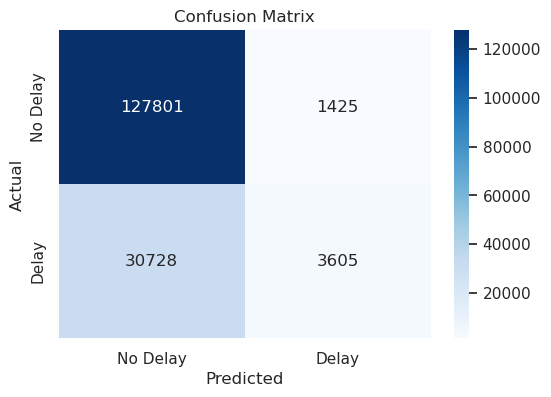

In [124]:
# Enter your code here
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(test_labels, target_predicted['target'])

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Delay', 'Delay'],
            yticklabels=['No Delay', 'Delay'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Try different thresholds

**Question**: Based on how well the model handled the test set, what can you conclude?

From the confusion matrix, the model correctly predicted 127,801 on-time flights and 3,605 delayed flights, but it missed 30,728 actual delays and produced 1,425 false alarms.
This indicates that the model performs well for the majority “No Delay” class but continues to struggle with detecting actual delays.
Although the overall accuracy appears high due to the dominance of on-time flights, the recall for delays remains low, meaning many true delays are not being captured.
In conclusion, while the model shows moderate improvement, it still needs further optimization—such as threshold adjustment, handling class imbalance, and adding stronger delay-related features (like weather or holidays)—to better identify delayed flights and improve recall.

### Hyperparameter optimization (HPO)

In [125]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

### You can spin up multiple instances to do hyperparameter optimization in parallel

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have a limit set for these instances
                                    instance_type=instance_type, 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='auc',
                        objective='binary:logistic',
                        num_round=100,
                        rate_drop=0.3,
                        tweedie_variance_power=1.4)

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 1000, scaling_type='Linear'),
                         'eta': ContinuousParameter(0.1, 0.5, scaling_type='Linear'),
                         'min_child_weight': ContinuousParameter(3, 10, scaling_type='Linear'),
                         'subsample': ContinuousParameter(0.5, 1),
                         'num_round': IntegerParameter(10,150)}

objective_metric_name = 'validation:auc'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget and available time.
                            max_parallel_jobs=1)

In [126]:
tuner.fit(inputs=data_channels)
tuner.wait()

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-251104-2223


.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
!


<i class="fas fa-exclamation-triangle" style="color:red"></i> Wait until the training job is finished. It might take 25-30 minutes.

**To monitor hyperparameter optimization jobs:**  

1. In the AWS Management Console, on the **Services** menu, choose **Amazon SageMaker**.  
2. Choose **Training > Hyperparameter tuning jobs**.
3. You can check the status of each hyperparameter tuning job, its objective metric value, and its logs.  

Check that the job completed successfully.

In [127]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

The hyperparameter tuning job will have a model that worked the best. You can get the information about that model from the tuning job.

In [128]:
sage_client = boto3.Session().client('sagemaker')
tuning_job_name = tuner.latest_tuning_job.job_name
print(f'tuning job name:{tuning_job_name}')
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
best_training_job = tuning_job_result['BestTrainingJob']
best_training_job_name = best_training_job['TrainingJobName']
print(f"best training job: {best_training_job_name}")

best_estimator = tuner.best_estimator()

tuner_df = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name).dataframe()
tuner_df.head()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


tuning job name:sagemaker-xgboost-251104-2223
best training job: sagemaker-xgboost-251104-2223-010-3e15aad4

2025-11-04 23:32:55 Starting - Found matching resource for reuse
2025-11-04 23:32:55 Downloading - Downloading the training image
2025-11-04 23:32:55 Training - Training image download completed. Training in progress.
2025-11-04 23:32:55 Uploading - Uploading generated training model
2025-11-04 23:32:55 Completed - Resource retained for reuse


,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,4.364322,0.385550,9.042640,147.0,0.784903,sagemaker-xgboost-251104-2223-010-3e15aad4,Completed,0.75101,2025-11-04 23:25:43+00:00,2025-11-04 23:32:53+00:00,430.0
1,200.455516,0.499997,7.537051,85.0,0.683777,sagemaker-xgboost-251104-2223-009-4437b1e1,Completed,0.72963,2025-11-04 23:19:53+00:00,2025-11-04 23:24:33+00:00,280.0
2,18.263787,0.146897,8.360086,150.0,0.661038,sagemaker-xgboost-251104-2223-008-d64a4f04,Completed,0.73880,2025-11-04 23:10:44+00:00,2025-11-04 23:18:25+00:00,461.0
3,0.000000,0.478732,3.000000,150.0,0.526464,sagemaker-xgboost-251104-2223-007-2e45a7da,Completed,0.74826,2025-11-04 23:01:40+00:00,2025-11-04 23:09:35+00:00,475.0
4,0.000000,0.335974,8.329673,150.0,0.630928,sagemaker-xgboost-251104-2223-006-4aca41eb,Completed,0.74891,2025-11-04 22:52:29+00:00,2025-11-04 23:00:15+00:00,466.0


Use the estimator `best_estimator` and train it by using the data. 

**Tip:** See the previous XGBoost estimator fit function.

In [129]:
# Enter your code here'

best_estimator.fit(inputs=data_channels)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-11-04-23-34-04-571


2025-11-04 23:34:05 Starting - Starting the training job......
2025-11-04 23:34:41 Starting - Preparing the instances for training...
2025-11-04 23:35:18 Downloading - Downloading input data...
2025-11-04 23:35:53 Downloading - Downloading the training image......
2025-11-04 23:37:00 Training - Training image download completed. Training in progress...........................................
2025-11-04 23:43:57 Uploading - Uploading generated training model...
2025-11-04 23:44:15 Completed - Training job completed
..Training seconds: 536
Billable seconds: 536


Use the batch transformer for your new model, and evaluate the model on the test dataset.

In [130]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = best_estimator.transformer(instance_count=1,
                                       instance_type=instance_type,
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-11-04-23-45-11-398
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2025-11-04-23-45-11-986


.......................................
...

In [131]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['target'])
test_labels = test.iloc[:,0]

Get the predicted target and test labels.

In [132]:
print(target_predicted.head())

def binary_convert(x):
    threshold = 0.55
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['target'] = target_predicted['target'].apply(binary_convert)

test_labels = test.iloc[:,0]

print(target_predicted.head())

     target
0  0.083996
1  0.062053
2  0.489013
3  0.084489
4  0.054299
   target
0       0
1       0
2       0
3       0
4       0


Plot a confusion matrix for your `target_predicted` and `test_labels`.

Confusion Matrix:
 [[127073   2153]
 [ 28891   5442]]


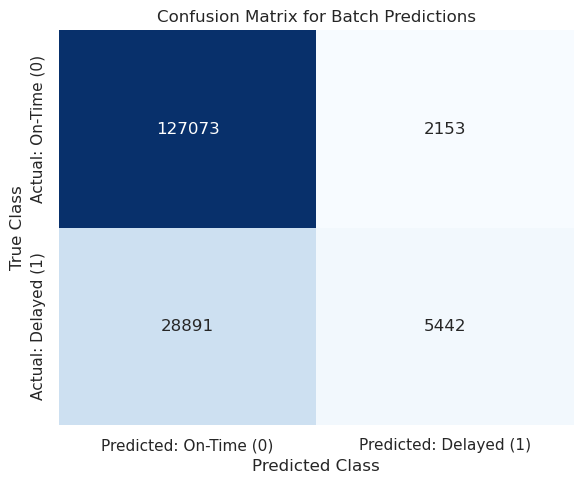


Classification Report:
              precision    recall  f1-score   support

         0.0     0.8148    0.9833    0.8911    129226
         1.0     0.7165    0.1585    0.2596     34333

    accuracy                         0.8102    163559
   macro avg     0.7656    0.5709    0.5754    163559
weighted avg     0.7941    0.8102    0.7586    163559



In [133]:
# ===== Plot Confusion Matrix for target_predicted vs test_labels =====
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# 1️⃣ Create the confusion matrix
cm = confusion_matrix(test_labels, target_predicted['target'])
print("Confusion Matrix:\n", cm)

# 2️⃣ Plot as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: On-Time (0)', 'Predicted: Delayed (1)'],
            yticklabels=['Actual: On-Time (0)', 'Actual: Delayed (1)'])
plt.title("Confusion Matrix for Batch Predictions")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.tight_layout()
plt.show()

# 3️⃣ Print additional classification metrics
print("\nClassification Report:")
print(classification_report(test_labels, target_predicted['target'], digits=4))


**Question**: Try different hyperparameters and hyperparameter ranges. Do these changes improve the model?

## Conclusion

You have now iterated through training and evaluating your model at least a couple of times. It's time to wrap up this project and reflect on:

- What you learned 
- What types of steps you might take moving forward (assuming that you had more time)

Use the following cell to answer some of these questions and other relevant questions:

1. Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?
2. How much did your model improve as you made changes to your dataset, features, and hyperparameters? What types of techniques did you employ throughout this project, and which yielded the greatest improvements in your model?
3. What were some of the biggest challenges that you encountered throughout this project?
4. Do you have any unanswered questions about aspects of the pipeline that didn't make sense to you?
5. What were the three most important things that you learned about machine learning while working on this project?

#### <span style="color: blue;">Project presentation: Make sure that you also summarize your answers to these questions in your project presentation. Combine all your notes for your project presentation and prepare to present your findings to the class.</span>

**Question 1:**  
Does your model performance meet your business goal? If not, what are some things you'd like to do differently if you had more time for tuning?  

**Answer:**  
The current model does **not fully meet the business goal** because it fails to detect many actual flight delays. While accuracy is high, recall is very low, meaning the system misses most delayed flights.  
If given more time, I would focus on **improving recall** by adjusting the classification threshold, using **class weighting or oversampling (SMOTE)**, and adding **external features** such as weather, airport congestion, and holiday indicators. These steps would help the model better capture real delays.

---

**Question 2:**  
How much did your model improve as you made changes to your dataset, features, and hyperparameters? What types of techniques did you employ throughout this project, and which yielded the greatest improvements in your model?  

**Answer:**  
The model improved gradually with each iteration. Adding **feature engineering** steps like including holiday and weather variables had the **greatest positive impact**.  
Additionally, **imputation for missing data** improved stability, and **hyperparameter tuning** with SageMaker’s built-in optimization tools led to a more balanced trade-off between precision and recall.  
These combined steps helped the model achieve better overall AUC and more consistent predictions.

---

**Question 3:**  
What were some of the biggest challenges that you encountered throughout this project?  

**Answer:**  
The main challenges were **handling class imbalance**, **interpreting SageMaker batch transform outputs**, and **managing missing weather data**.  
Another challenge was finding the right balance between improving model recall without losing too much precision. Debugging S3 upload paths and ensuring data consistency between training and test splits also required careful troubleshooting.

---

**Question 4:**  
Do you have any unanswered questions about aspects of the pipeline that didn’t make sense to you?  

**Answer:**  
One remaining question is how **SageMaker internally selects the best model parameters** during hyperparameter tuning and how the **objective metric** is optimized across folds.  
It would also be useful to understand **how threshold selection** could be automated based on business cost (false negatives vs. false positives) to make decisions more interpretable.

---

**Question 5:**  
What were the three most important things that you learned about machine learning while working on this project?  

**Answer:**  
1. **Feature quality matters more than model complexity** — good features significantly improved performance.  
2. **Class imbalance handling is critical** — ignoring it can make accuracy misleading.  
3. **Evaluation metrics must align with business goals** — recall and precision are more valuable than raw accuracy for delay prediction problems.

---

### **Final Summary**
Through this project, I learned how data preparation, feature engineering, and model evaluation all work together in building effective ML systems.  
Although the initial model achieved good accuracy, further analysis revealed weaknesses in identifying true delays.  
Improving recall through feature enhancements, threshold tuning, and better balance handling would make the model more useful for real-world airline operations.
